**Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import math
import random
import matplotlib.pyplot as plt
import shutil
from sklearn.preprocessing import QuantileTransformer # 将数据转换为均匀分布或正态分布
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

**Load Dataset from Google Drive**

In [2]:
df =pd.read_csv("processed_IIoT.csv")
#del df[df.columns[0]]
df.head()

,arp.opcode,arp.hw.size,icmp.checksum,icmp.seq_le,icmp.unused,http.content_length,http.response,http.tls_port,tcp.ack,tcp.ack_raw,...,mqtt.conack.flags-1471199,mqtt.conack.flags-1574358,mqtt.conack.flags-1574359,mqtt.protoname-0,mqtt.protoname-0.0,mqtt.protoname-MQTT,mqtt.topic-0,mqtt.topic-0.0,mqtt.topic-Temperature_and_Humidity,Attack_type
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.292691e+09,...,False,False,False,True,False,False,True,False,False,Normal
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,2.210188e+09,...,False,False,False,True,False,False,True,False,False,Normal
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.010767e+06,...,False,False,False,False,True,False,False,True,False,DDoS_HTTP
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.536111e+08,...,False,False,False,True,False,False,True,False,False,Normal
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,3.854373e+09,...,False,False,False,True,False,False,True,False,False,Normal


In [3]:
df.shape

(1909671, 96)

In [4]:
# 将bool类型数据转为unit8数据，如果数据已经转换了，该步骤可以忽略
bool_columns = df.select_dtypes(include=['bool']).columns # 选择数据类型为bool的所有列
df[bool_columns] = df[bool_columns].astype('uint8') # 转为unit8数据类型
df.head()

,arp.opcode,arp.hw.size,icmp.checksum,icmp.seq_le,icmp.unused,http.content_length,http.response,http.tls_port,tcp.ack,tcp.ack_raw,...,mqtt.conack.flags-1471199,mqtt.conack.flags-1574358,mqtt.conack.flags-1574359,mqtt.protoname-0,mqtt.protoname-0.0,mqtt.protoname-MQTT,mqtt.topic-0,mqtt.topic-0.0,mqtt.topic-Temperature_and_Humidity,Attack_type
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.292691e+09,...,0,0,0,1,0,0,1,0,0,Normal
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,2.210188e+09,...,0,0,0,1,0,0,1,0,0,Normal
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.010767e+06,...,0,0,0,0,1,0,0,1,0,DDoS_HTTP
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.536111e+08,...,0,0,0,1,0,0,1,0,0,Normal
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,3.854373e+09,...,0,0,0,1,0,0,1,0,0,Normal


In [5]:
# Transform all features into the scale of [0,1]
# 对数值特征进行归一化处理
numeric_features = df.dtypes[df.dtypes != 'object'].index
scaler = QuantileTransformer() # 创建对象
df[numeric_features] = scaler.fit_transform(df[numeric_features]) # 对制定的数值特征列进行归一化处理

In [6]:
# Multiply the feature values by 255 to transform them into the scale of [0,255]
# 将DataFrame中的数值特征列的值乘以255，以将这些特征值转换到[0, 255]的范围内
df[numeric_features] = df[numeric_features].apply(lambda x: (x*255))

df.describe()

,arp.opcode,arp.hw.size,icmp.checksum,icmp.seq_le,icmp.unused,http.content_length,http.response,http.tls_port,tcp.ack,tcp.ack_raw,...,mqtt.conack.flags-1471198,mqtt.conack.flags-1471199,mqtt.conack.flags-1574358,mqtt.conack.flags-1574359,mqtt.protoname-0,mqtt.protoname-0.0,mqtt.protoname-MQTT,mqtt.topic-0,mqtt.topic-0.0,mqtt.topic-Temperature_and_Humidity
count,1.909671e+06,1.909671e+06,1.909671e+06,1.909671e+06,1909671.0,1.909671e+06,1.909671e+06,1909671.0,1.909671e+06,1.909671e+06,...,1.909671e+06,1.909671e+06,1.909671e+06,1.909671e+06,1.909671e+06,1.909671e+06,1.909671e+06,1.909671e+06,1.909671e+06,1.909671e+06
mean,3.338271e-03,3.338271e-03,8.971650e+00,1.039102e+01,0.0,5.837198e+00,4.353506e+00,0.0,1.229137e+02,1.241497e+02,...,2.670617e-04,2.670617e-04,1.201778e-03,1.201778e-03,1.710504e+02,7.286418e+01,1.108546e+01,1.710508e+02,7.286418e+01,1.108506e+01
std,9.226313e-01,9.226313e-01,4.651033e+01,4.981717e+01,0.0,3.786266e+01,3.303319e+01,0.0,7.801512e+01,7.905426e+01,...,2.609611e-01,2.609611e-01,5.535811e-01,5.535811e-01,1.198316e+02,1.152006e+02,5.199911e+01,1.198315e+02,1.152006e+02,5.199821e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,6.572823e+01,6.396704e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,1.207357e+02,1.270588e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.550000e+02,0.000000e+00,0.000000e+00,2.550000e+02,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,1.902928e+02,1.922702e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.550000e+02,2.550000e+02,0.000000e+00,2.550000e+02,2.550000e+02,0.000000e+00
max,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,0.0,2.550000e+02,2.550000e+02,0.0,2.550000e+02,2.550000e+02,...,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02


**Generate images corresponding to each class**

In [7]:
#Generate images corresponding to each class
#根据Attack_type列的值将DataFrame分割成多个子DataFrame，每个子DataFrame对应一个攻击类型。然后，删除每个子DataFrame中的Attack_type列，以便生成对应类别的图像
df0=df[df['Attack_type']=='Normal'].drop(['Attack_type'],axis=1)
df1=df[df['Attack_type']=='DDoS_UDP'].drop(['Attack_type'],axis=1)
df2=df[df['Attack_type']=='DDoS_ICMP'].drop(['Attack_type'],axis=1)
df3=df[df['Attack_type']=='SQL_injection'].drop(['Attack_type'],axis=1)
df4=df[df['Attack_type']=='DDoS_TCP'].drop(['Attack_type'],axis=1)
df5=df[df['Attack_type']=='Vulnerability_scanner'].drop(['Attack_type'],axis=1)
df6=df[df['Attack_type']=='Password'].drop(['Attack_type'],axis=1)
df7=df[df['Attack_type']=='DDoS_HTTP'].drop(['Attack_type'],axis=1)
df8=df[df['Attack_type']=='Uploading'].drop(['Attack_type'],axis=1)
df9=df[df['Attack_type']=='Backdoor'].drop(['Attack_type'],axis=1)
df10=df[df['Attack_type']=='Port_Scanning'].drop(['Attack_type'],axis=1)
df11=df[df['Attack_type']=='XSS'].drop(['Attack_type'],axis=1)
df12=df[df['Attack_type']=='Ransomware'].drop(['Attack_type'],axis=1)
df13=df[df['Attack_type']=='Fingerprinting'].drop(['Attack_type'],axis=1)
df14=df[df['Attack_type']=='MITM'].drop(['Attack_type'],axis=1)

In [8]:
# ***********Generate 95*95 color images for class 0 (Normal)************
# 生成95x95的彩色图像，并将这些图像保存到指定路径
count=0
ims = []

image_path = "train/Normal/"
os.makedirs(image_path)

for i in range(0, len(df0)):
    count=count+1
    if count<=285:
        im=df0.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(95,95,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

In [9]:
# ***********Generate 95*95 color images for class 1 (DDoS_UDP)************
count=0
ims = []

image_path = "train/DDoS_UDP/"
os.makedirs(image_path)

for i in range(0, len(df1)):
    count=count+1
    if count<=285:
        im=df1.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(95,95,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

In [13]:
# ***********Generate 95*95 color images for class 2 (DDoS_ICMP)************
count=0
ims = []

image_path = "train/DDoS_ICMP/"
os.makedirs(image_path)

for i in range(0, len(df2)):
    count=count+1
    if count<=285:
        im=df2.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(95,95,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

In [14]:
# ***********Generate 95*95 color images for class 3 (SQL_injection )************
count=0
ims = []

image_path = "train/SQL_injection/"
os.makedirs(image_path)

for i in range(0, len(df3)):
    count=count+1
    if count<=285:
        im=df3.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(95,95,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

In [15]:
# ***********Generate 95*95 color images for class 4 (DDoS_TCP)************
count=0
ims = []

image_path = "train/DDoS_TCP/"
os.makedirs(image_path)

for i in range(0, len(df4)):
    count=count+1
    if count<=285:
        im=df4.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(95,95,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

In [16]:
# ***********Generate 95*95 color images for class 5 (Vulnerability_scanner)************
count=0
ims = []

image_path = "train/Vulnerability_scanner/"
os.makedirs(image_path)

for i in range(0, len(df5)):
    count=count+1
    if count<=285:
        im=df5.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(95,95,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

In [17]:
# ***********Generate 95*95 color images for class 6 (Password)************
count=0
ims = []

image_path = "train/Password/"
os.makedirs(image_path)

for i in range(0, len(df6)):
    count=count+1
    if count<=285:
        im=df6.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(95,95,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

In [18]:
# *Generate 95*95 color images for class 7 (DDoS_HTTP)***
count=0
ims = []

image_path = "train/DDoS_HTTP/"
os.makedirs(image_path)

for i in range(0, len(df7)):
    count=count+1
    if count<=285:
        im=df7.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(95,95,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

In [19]:
# *Generate 95*95 color images for class 8 (Uploading)***
count=0
ims = []

image_path = "train/Uploading/"
os.makedirs(image_path)

for i in range(0, len(df8)):
    count=count+1
    if count<=285:
        im=df8.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(95,95,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

In [20]:
# ********Generate 95*95 color images for class 9 (Backdoor)***
count=0
ims = []

image_path = "train/Backdoor/"
os.makedirs(image_path)

for i in range(0, len(df9)):
    count=count+1
    if count<=285:
        im=df9.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(95,95,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

In [21]:
# ********Generate 95*95 color images for class 10 (Port_Scanning)***
count=0
ims = []

image_path = "train/Port_Scanning/"
os.makedirs(image_path)

for i in range(0, len(df10)):
    count=count+1
    if count<=285:
        im=df10.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(95,95,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []


In [22]:
# ********Generate 95*95 color images for class 11 (XSS)***
count=0
ims = []

image_path = "train/XSS/"
os.makedirs(image_path)

for i in range(0, len(df11)):
    count=count+1
    if count<=285:
        im=df11.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(95,95,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

In [23]:
# ********Generate 95*95 color images for class 12 (Ransomware)***
count=0
ims = []

image_path = "train/Ransomware/"
os.makedirs(image_path)

for i in range(0, len(df12)):
    count=count+1
    if count<=285:
        im=df12.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(95,95,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

In [31]:
# ********Generate 95*95 color images for class 13 (Fingerprinting)***
count=0
ims = []

image_path = "train/Fingerprinting/"
os.makedirs(image_path)

for i in range(0, len(df13)):
    count=count+1
    if count<=285:
        im=df13.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(95,95,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

In [25]:
# ********Generate 95*95 color images for class 14 (MITM)***
count=0
ims = []

image_path = "train/MITM/"
os.makedirs(image_path)

for i in range(0, len(df14)):
    count=count+1
    if count<=285:
        im=df14.iloc[i].values
        ims=np.append(ims,im)
    else:
        ims=np.array(ims).reshape(95,95,3)
        array = np.array(ims, dtype=np.uint8)
        new_image = Image.fromarray(array)
        new_image.save(image_path+str(i)+'.png')
        count=0
        ims = []

**Display samples for each category**

In [29]:
img1 = Image.open('train/Normal/1002143.png')
img2 = Image.open('train/DDoS_UDP/108965.png')
img3 = Image.open('train/DDoS_ICMP/15157.png')
img4 = Image.open('train/SQL_injection/14299.png')
img5 = Image.open('train/DDoS_TCP/13441.png')
img6 = Image.open('train/Vulnerability_scanner/13727.png')
img7 = Image.open('train/Password/12011.png')
img8 = Image.open('train/DDoS_HTTP/16015.png')
img9 = Image.open('train/Uploading/15157.png')
img10 = Image.open('train/Backdoor/17731.png')
img11 = Image.open('train/Port_Scanning/12869.png')
img12 = Image.open('train/XSS/4003.png')
img13 = Image.open('train/Ransomware/6863.png')
img14 = Image.open('train/Fingerprinting/285.png')
img15 = Image.open('train/MITM/285.png')

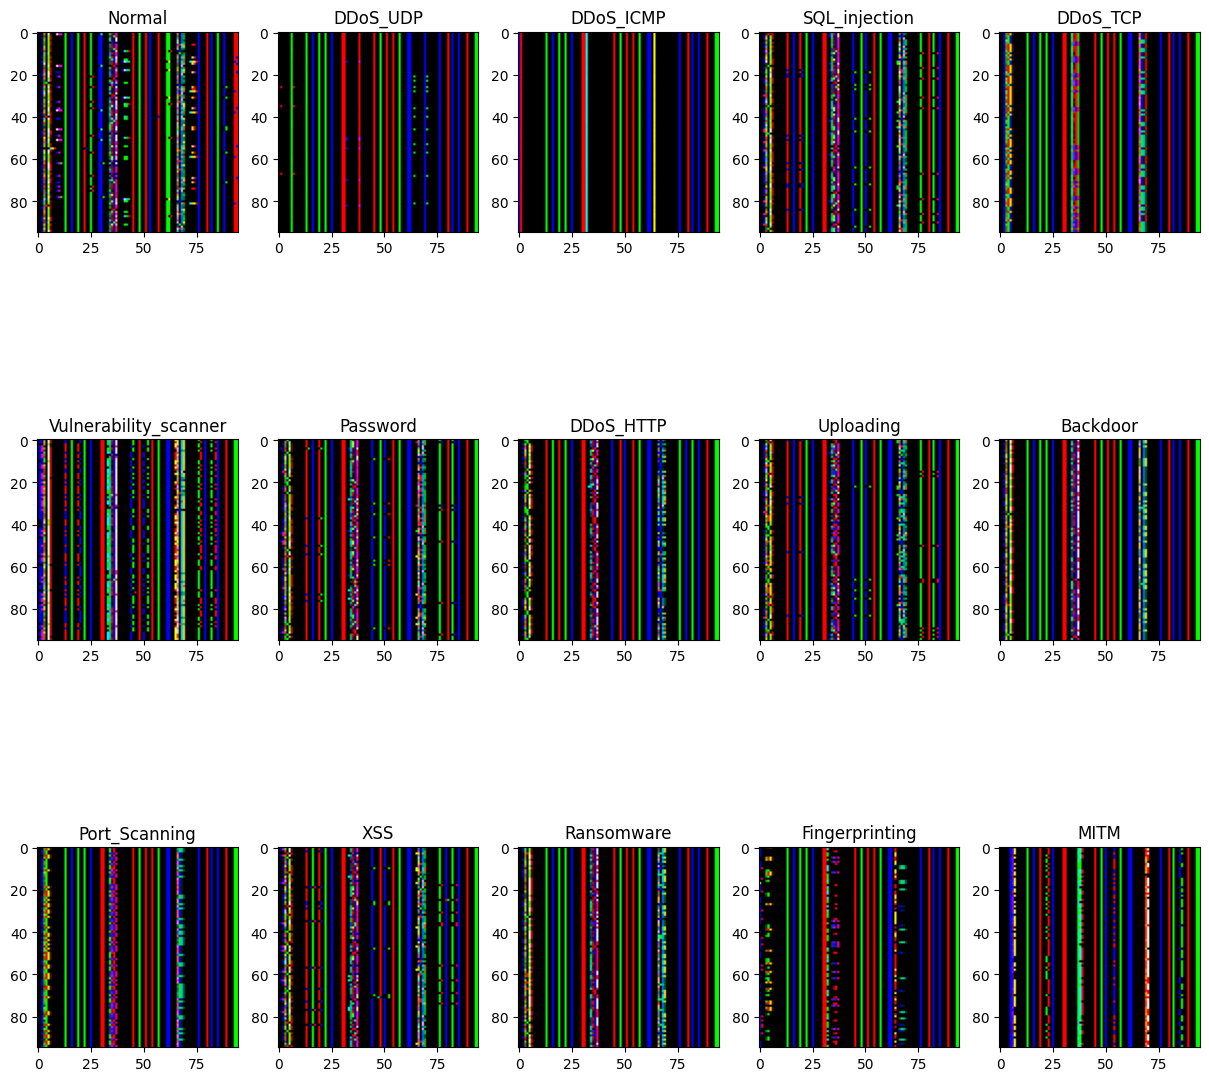

In [30]:
plt.figure(figsize=(15, 15))
plt.subplot(3,5,1)
plt.imshow(img1)
plt.title("Normal")
plt.subplot(3,5,2)
plt.imshow(img2)
plt.title("DDoS_UDP")
plt.subplot(3,5,3)
plt.imshow(img3)
plt.title("DDoS_ICMP")
plt.subplot(3,5,4)
plt.imshow(img4)
plt.title("SQL_injection")
plt.subplot(3,5,5)
plt.imshow(img5)
plt.title("DDoS_TCP")
plt.subplot(3,5,6)
plt.imshow(img6)
plt.title("Vulnerability_scanner")
plt.subplot(3,5,7)
plt.imshow(img7)
plt.title("Password")
plt.subplot(3,5,8)
plt.imshow(img8)
plt.title("DDoS_HTTP")
plt.subplot(3,5,9)
plt.imshow(img9)
plt.title("Uploading")
plt.subplot(3,5,10)
plt.imshow(img10)
plt.title("Backdoor")
plt.subplot(3,5,11)
plt.imshow(img11)
plt.title("Port_Scanning")
plt.subplot(3,5,12)
plt.imshow(img12)
plt.title("XSS")
plt.subplot(3,5,13)
plt.imshow(img13)
plt.title("Ransomware")
plt.subplot(3,5,14)
plt.imshow(img14)
plt.title("Fingerprinting")
plt.subplot(3,5,15)
plt.imshow(img15)
plt.title("MITM")

plt.show()  # display it

**Split the training and test set**
28开

In [33]:
# Create folders to store images
# 创建训练集和测试集
Train_Dir='train/'
Val_Dir='test/'
allimgs=[]
for subdir in os.listdir(Train_Dir):
    for filename in os.listdir(os.path.join(Train_Dir,subdir)):
        filepath=os.path.join(Train_Dir,subdir,filename)
        allimgs.append(filepath)
print(len(allimgs)) # Print the total number of images

#split a test set from the dataset, train/test size = 80%/20%
Numbers=len(allimgs)//5 	#size of test set (20%)

def mymovefile(srcfile,dstfile):
    if not os.path.isfile(srcfile):
        print ("%s not exist!"%(srcfile))
    else:
        fpath,fname=os.path.split(dstfile)
        if not os.path.exists(fpath):
            os.makedirs(fpath)
        shutil.move(srcfile,dstfile)

Numbers

val_imgs=random.sample(allimgs,Numbers)
for img in val_imgs:
    dest_path=img.replace(Train_Dir,Val_Dir)
    mymovefile(img,dest_path)
print('Finish creating test set')

6669
Finish creating test set


**Resize the images 224*224 for better CNN training**

In [34]:
#将 图像缩放到224x224像素
def get_224(folder,dstdir):
    imgfilepaths=[]
    for root,dirs,imgs in os.walk(folder):
        for this_img in imgs:
            this_img_path=os.path.join(root,this_img)
            imgfilepaths.append(this_img_path)
    for this_img_path in imgfilepaths:
        dir_name,filename=os.path.split(this_img_path)
        dir_name=dir_name.replace(folder,dstdir)
        new_file_path=os.path.join(dir_name,filename)
        if not os.path.exists(dir_name):
            os.makedirs(dir_name)
        img=cv2.imread(this_img_path)
        img=cv2.resize(img,(224,224))
        cv2.imwrite(new_file_path,img)
    print('Finish resizing'.format(folder=folder))

DATA_DIR_224='train_A/'
get_224(folder='train/',dstdir=DATA_DIR_224)

DATA_DIR2_224='test_A/'
get_224(folder='test/',dstdir=DATA_DIR2_224)

Finish resizing
Finish resizing
